# Read an ISRed image mosaic from the butler and fit ghost spots

## Setup and imports

In [1]:
! eups list -s lsst_distrib

   g4213664e8e+b08e1c1b0b 	current w_2024_04 setup


In [2]:
# %matplotlib ipympl

# plotting
import pylab as plt
import numpy as np

# butler
from lsst.daf.butler import Butler

# isr and display
import lsst.afw.display as afwDisplay
from lsst.afw.image import Image

# camera stuff
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu
from lsst.obs.lsst import LsstCam

# Astropy nice plotting
from astropy.visualization import imshow_norm, MinMaxInterval, AsinhStretch, LinearStretch, \
                                  SqrtStretch,ContrastBiasStretch,ZScaleInterval, \
                                  AsymmetricPercentileInterval,ManualInterval



## Helpers

In [3]:
def displayExposure(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    afw_display.setImageColormap(cmap='gray')
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImage(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    #afw_display.scale('linear', min=-5, max=10)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImageGhosts(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(16,16))
    afw_display = afwDisplay.Display(1)
    #afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', min=0, max=20)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    plt.gca().axis('off')
    return afw_display



In [4]:
def getRefsFromObsId(butler, obs_id="MC_C_20230619_000087", detector=None):
    if detector is not None:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'",
                                                  detector=detector)))
        print(f'Found {len(refs)} CCD exposure.')
        # print(butler.get(refs[0]).info.getDetector().getName())

    else:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'")))
        print(f'Found {len(refs)} CCD exposures.')
        # print(butler.get(refs[0]).info.getVisitInfo())
    exposure_refs = {ref.dataId['detector']: ref for ref in refs}
    return exposure_refs



In [5]:
def array_from_mosaic(mosaic):
    mar = mosaic.getArray()
    mma= np.ma.filled(np.ma.masked_values(mar,0.0000),np.nan)
    return mma

def show_hv_slices(imgarray, vpix, hpix, ccdname):
    plt.rcParams["figure.figsize"] = [12, 6]
    fig, ax = plt.subplots(1, 2)
    subax = imgarray[vpix]
    x = range(len(subax))
    ax[0].plot(x, subax)
    ax[0].set_title(f'Horizontal slice on {ccdname} at pixel {vpix}')
    subay = np.transpose(imgarray)[hpix]
    y = range(len(subay))
    ax[1].plot(y, subay)
    ax[1].set_title(f'Vertical slice on {ccdname} at pixel {hpix}')


## Connect to the Butler repository

In [6]:
import lsst.daf.butler as daf_butler
repo = "/sdf/data/rubin/repo/ir2"
butler = daf_butler.Butler(repo)

In [7]:
def displayImage(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    #afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', min=-5, max=50000)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    return afw_display


In [8]:
collections = butler.registry.queryCollections(f"u/bregeon/eo_focal_plane_mosaic*",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
for item in collections[:5]:
    print(item)

u/bregeon/eo_focal_plane_mosaic_3023062500401_w_2024_12


In [9]:
myref=list(set(butler.registry.queryDatasets(datasetType='eoFpMosaic',
                                       instrument='LSSTCam',
                                       collections=collections)))

In [10]:
imageF = butler.get(myref[0])

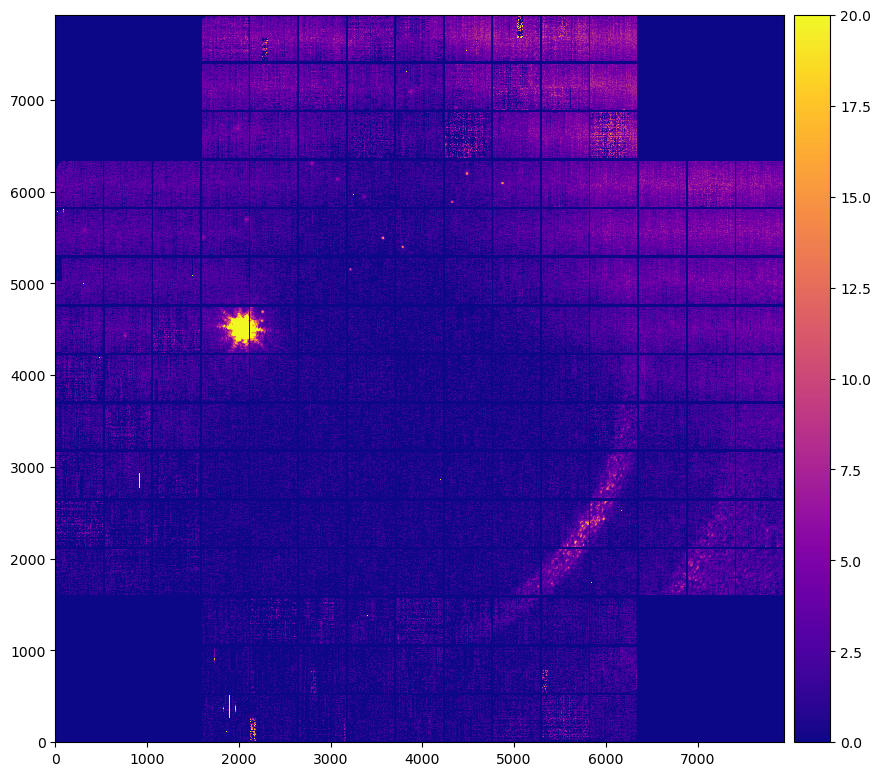

In [31]:
afwDisplay.setDefaultBackend('matplotlib') 
fig = plt.figure(figsize=(10,10))
afw_display = afwDisplay.Display(1)
#afw_display.scale('asinh', 'zscale')
afw_display.scale('linear', min=0, max=20)
afw_display.setImageColormap(cmap='plasma')
afw_display.mtv(imageF)
#plt.title(title)
#plt.gca().axis('off')
#afw_display.interact()
#afw_display.zoom(zoomfac=50, colc=750, rowc=4500)


In [37]:
from lsst.geom import Box2I, Point2I, Extent2I
x_center = 760
y_center = 4440
dd = 100
box2 = Box2I(minimum=Point2I(x=x_center-dd, y=y_center-dd), maximum=Point2I(x=x_center+dd, y=y_center+dd))
sub2 = imageF[box2]   # same as no ImageOrigin argument
print(sub2.getX0(), sub2.getY0())

660 4340


<Figure size 1000x1000 with 0 Axes>

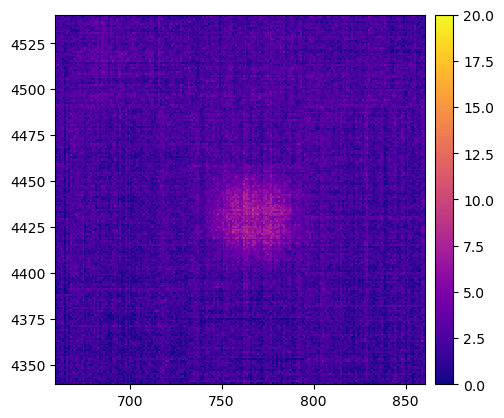

In [13]:
fig2 = plt.figure(figsize=(10,10))
afw_display2 = afwDisplay.Display(2)
afw_display2.scale('linear', min=0, max=20)
afw_display2.setImageColormap(cmap='plasma')
afw_display2.mtv(sub2)


In [41]:
box2.getCenter(), box2.x.range(), box2.y.range(), box2.grid() 

(Point2D(760, 4440),
 range(660, 861),
 range(4340, 4541),
 [array([[660, 661, 662, ..., 858, 859, 860],
         [660, 661, 662, ..., 858, 859, 860],
         [660, 661, 662, ..., 858, 859, 860],
         ...,
         [660, 661, 662, ..., 858, 859, 860],
         [660, 661, 662, ..., 858, 859, 860],
         [660, 661, 662, ..., 858, 859, 860]], dtype=int32),
  array([[4340, 4340, 4340, ..., 4340, 4340, 4340],
         [4341, 4341, 4341, ..., 4341, 4341, 4341],
         [4342, 4342, 4342, ..., 4342, 4342, 4342],
         ...,
         [4538, 4538, 4538, ..., 4538, 4538, 4538],
         [4539, 4539, 4539, ..., 4539, 4539, 4539],
         [4540, 4540, 4540, ..., 4540, 4540, 4540]], dtype=int32)])

In [34]:
from scipy import optimize

def gaussian(bkg, height, center_x, center_y, width):
    """Returns a gaussian function with the given parameters"""
    width = float(width)
    bkg = float(bkg)
    return lambda x,y: bkg + height*np.exp(
                -(((center_x-x)/width)**2+((center_y-y)/width)**2)/2)

def moments(data):
    """Returns (height, x, y, width)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    height = data.max()
    bkg = data.mean()
    return bkg, height, x, y, width

def fitgaussian(data):
    """Returns (height, x, y, width)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    print(params)
    return p

In [44]:
# data
cutout = np.transpose(sub2.getArray())
# Fit centered in (100,100)
params = fitgaussian(cutout)
fit = gaussian(*params)

(2.342922, 9.471527, 100.21704053581973, 104.86008040780416, 50.617116238652855)


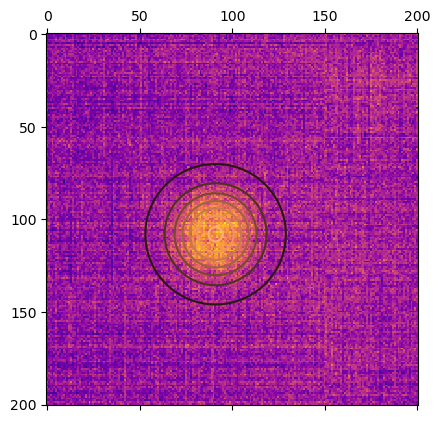

In [45]:
plt.matshow(cutout, cmap='plasma')
plt.contour(fit(*np.indices(cutout.shape)), cmap=plt.cm.copper)

In [46]:
# Move Gaussian to focal plane coordinates
rc_params = params.copy()
rc_params[2] = params[2]+sub2.getX0()
rc_params[3] = params[3]+sub2.getY0()
rc_fit = gaussian(*rc_params)
print(rc_params)


[2.15130540e+00 5.21075313e+00 7.67997786e+02 4.43094555e+03
 1.53770181e+01]


Center in camera bins coordinates: 767.9977857732981, 4430.945545782468, 5.210753125813677


<Figure size 1000x1000 with 0 Axes>

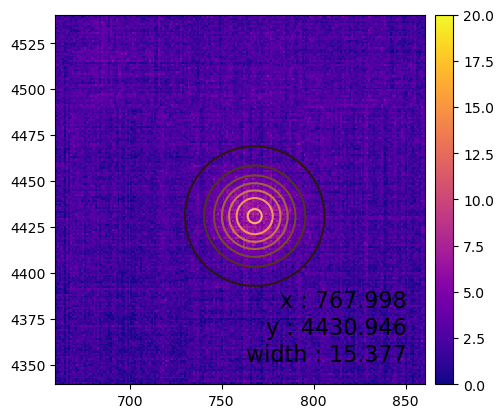

In [47]:
# plot ghosts stamp
fig3 = plt.figure(figsize=(10,10))
afw_display3 = afwDisplay.Display(3)
afw_display3.scale('linear', min=0, max=20)
afw_display3.setImageColormap(cmap='plasma')
afw_display3.mtv(sub2)
# plot gaussian contours 

plt.contour(box2.x.range(), box2.y.range(), rc_fit(*box2.grid()), cmap=plt.cm.copper)

ax = plt.gca()
(bkg, height, x, y, width) = rc_params
plt.text(0.95, 0.05, """
x : %.3f
y : %.3f
width : %.3f""" %(x, y, width),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

print(f'Center in camera bins coordinates: {x}, {y}, {height}')

In [ ]:
#show_hv_slices(imageF.getArray(), vpix=6300, hpix=2780, ccdname='random')

In [ ]:
#     from lsst.afw import cameraGeom
#    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
#    cam_x, cam_y = tx.getMapping().applyForward(np.vstack((x, y)))
#    return cam_x.ravel(), cam_y.ravel()